In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext google.cloud.bigquery

In [2]:
from google.cloud import bigquery

credential_path = r'../../BQ_Keypath/portfolio-331917-359fa79d51d1.json'
client = bigquery.Client.from_service_account_json(credential_path)

# define helper functions
def getQueryAsDF(query):
    return client.query(query).result().to_dataframe()

def getTableSchema(table):
    return client.get_table(table).schema

## 1. Population Growth Over Time
We will be looking at users signup rate year by year. This will give us insight for the platform growth. 

In [3]:
# understanding users table's schema
schema = getTableSchema('bigquery-public-data.stackoverflow.users')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, ()),
 SchemaField('age', 'STRING', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('location', 'STRING', 'NULLABLE', None, ()),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, ()),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, ())]

In [4]:
# since all field are NULLABLE modes, checking for nulls 
query = """
            SELECT 
                COUNT(*) AS null_count
            FROM
                `bigquery-public-data.stackoverflow.users`
            WHERE
                id IS NULL
                OR creation_date IS NULL
                OR last_access_date IS NULL;
        """

result = getQueryAsDF(query)
result

,null_count
0,0


In [5]:
# user signup count by year
query = """
            SELECT 
                EXTRACT (YEAR FROM creation_date) AS year,
                COUNT(*) AS signup_count
            FROM `bigquery-public-data.stackoverflow.users`
            GROUP BY 1
        """

result = getQueryAsDF(query)
result

,year,signup_count
0,2008,21646
1,2009,78007
2,2010,199205
3,2011,358720
4,2012,678857
5,2013,1122387
6,2014,1174726
7,2015,1252388
8,2016,1515482
9,2017,1726646


In [6]:
users_count = result['signup_count'].values

total_users_by_year = []
growth_perc = []
total_users_by_year.append(users_count[0])
growth_perc.append(100)

for i in range(len(users_count)):
    if i < len(users_count)-1:
        index = i+2
        total_users_by_year.append(np.sum(users_count[:index]))
        growth_perc.append(round(total_users_by_year[index-1]/total_users_by_year[i] * 100,2))

df = result
df['total_user_by_year'] = total_users_by_year
df['growth_perc'] = growth_perc
df

,year,signup_count,total_user_by_year,growth_perc
0,2008,21646,21646,100.00
1,2009,78007,99653,460.38
2,2010,199205,298858,299.90
3,2011,358720,657578,220.03
4,2012,678857,1336435,203.24
5,2013,1122387,2458822,183.98
6,2014,1174726,3633548,147.78
7,2015,1252388,4885936,134.47
8,2016,1515482,6401418,131.02
9,2017,1726646,8128064,126.97


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '2009'),
  Text(1, 0, '2010'),
  Text(2, 0, '2011'),
  Text(3, 0, '2012'),
  Text(4, 0, '2013'),
  Text(5, 0, '2014'),
  Text(6, 0, '2015'),
  Text(7, 0, '2016'),
  Text(8, 0, '2017'),
  Text(9, 0, '2018'),
  Text(10, 0, '2019'),
  Text(11, 0, '2020'),
  Text(12, 0, '2021')])

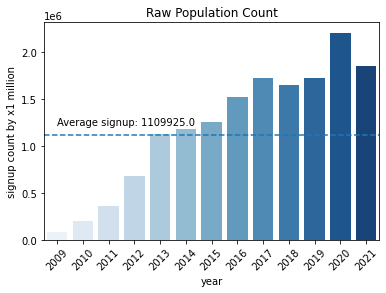

In [21]:
sns.barplot(data = df[1:], x = 'year', y = 'signup_count', palette = 'Blues')
avg_growth_count = np.average(df['signup_count'])
text_avg_growth_count = 'Average signup: {}'.format(round(avg_growth_count))
plt.axhline(avg_growth_count, ls = '--')
plt.text(0, avg_growth_count * 1.1, text_avg_growth_count)
plt.title('Raw Population Count')
plt.ylabel('signup count by x1 million')
plt.xticks(rotation = 45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '2009'),
  Text(1, 0, '2010'),
  Text(2, 0, '2011'),
  Text(3, 0, '2012'),
  Text(4, 0, '2013'),
  Text(5, 0, '2014'),
  Text(6, 0, '2015'),
  Text(7, 0, '2016'),
  Text(8, 0, '2017'),
  Text(9, 0, '2018'),
  Text(10, 0, '2019'),
  Text(11, 0, '2020'),
  Text(12, 0, '2021')])

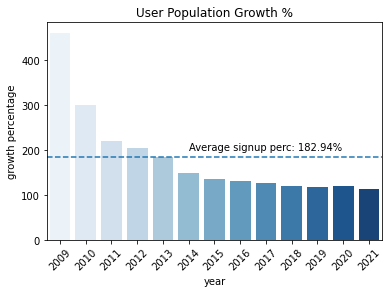

In [22]:
# excluding 2008 as it was the launch year.
sns.barplot(data = df[1:], x = 'year', y = 'growth_perc', palette = 'Blues')
avg_growth_perc = np.average(growth_perc[1:]) # adding reference line for average growth
text_avg_growth_perc = 'Average signup perc: {}{}'.format(round(avg_growth_perc,2),'%')
plt.axhline(avg_growth_perc, ls = '--')
plt.text(5, 200, text_avg_growth_perc)
plt.title('User Population Growth %')
plt.ylabel('growth percentage')
plt.xticks(rotation = 45)

Notice that after 1 year of the launch, the platform users grew over 400%. However, it is important to keep in mind the actual users count sign up is much smaller compare to the years after. Overall, we can be confident that the users population growth is in a healthy state where the yearly total new users counts are higher than average.

## 2. Understanding User Activity and Engagement. 
- Monthly Active Users(MAU): unique user post by comment, question or answer. 
- Active but not engaged users(signed in and visited the site but does not post)

In [ ]:
query = """
[WIP]
        SELECT 
            (pa.total_active + pq.total_active + pc.total_active) AS total,
            pq.year_month
        FROM 
            (SELECT
                CONCAT(EXTRACT (YEAR FROM creation_date), ' ', EXTRACT (MONTH FROM creation_date)) AS year_month,
                COUNT(DISTINCT owner_user_id) AS total_active
            FROM `bigquery-public-data.stackoverflow.posts_questions`
            GROUP BY 1
            ORDER BY 1) AS pq 
            JOIN (SELECT
                    CONCAT(EXTRACT (YEAR FROM creation_date), ' ', EXTRACT (MONTH FROM creation_date)) AS year_month,
                    COUNT(DISTINCT owner_user_id) AS total_active
                FROM `bigquery-public-data.stackoverflow.posts_answers`
                GROUP BY 1
                ORDER BY 1) AS pa ON pq.year_month = pa.year_month
            JOIN (SELECT
                    CONCAT(EXTRACT (YEAR FROM creation_date), ' ', EXTRACT (MONTH FROM creation_date)) AS year_month,
                    COUNT(DISTINCT user_id) AS total_active
                FROM `bigquery-public-data.stackoverflow.comments`
                GROUP BY 1
                ORDER BY 1) AS pc ON pq.year_month = pc.year_month
        ORDER BY 2
        """

result = getQueryAsDF(query)
result